In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [2]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsTh_0008.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(378,374)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (101.83504179, 3.96152952)>


In [3]:
x = [101.812093,101.806429,101.797486,101.771853,101.819136,101.810250,101.818790,101.818916,101.807737,101.788950]
y = [3.974229,3.963025,3.990697,3.942408,3.975548,3.939188,3.986519,3.946385,3.9309082,4.006325]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\1I Reduced')
file = 'reduceducdTh_0008.fits'
image = pf.getdata(file)

a = np.array(a)
b = np.array(b)
a = a
b = b
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=4.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -5<(k-xref)<5 and -5<(l-yref)<5:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[511.07697418 542.9636232  595.5372174  739.97076266 470.80754873
 519.90948553 473.32886233 470.6324873  533.89494012 645.18655645]
[303.1705548  367.74185851 209.25065305 487.60002736 295.2933896
 504.43524288 232.31919431 462.73995551 552.08149898 119.89101345]
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
383  507.6578 302.65882 0.61725242 ...   0 64.470086 2.8923351 -1.1531215
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
456 540.05185 367.44374 0.62013571 ...   0 1260.2397 61.623113 -4.4743591
 id xcentroid ycentroid sharpness ... sky    peak      flux      mag    
--- --------- --------- --------- ... --- --------- --------- ----------
259 594.98736 208.65957 0.6194212 ...   0 1141.1058 55.909082 -4.3687059
 id xcentroid ycentroid sharpness  ... sky    peak     flux      mag    

In [9]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=3) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)
mags.remove(mags[0])
magserrors.remove(magserrors[0])

In [20]:
len(ma)

[-10.129009070360349, -10.061888574257454, -10.281433359897429, -10.310473277496756, -10.807788071154285, -10.157706022690212, -9.688000246242584, -9.655419033634647, -9.890496868106158]


Beta: [  0.54745372 -17.57390657]
Beta Std Error: [0.04001949 0.54620893]
Beta Covariance: [[ 0.31346427 -4.27426144]
 [-4.27426144 58.3932446 ]]
Residual Variance: 0.005109224546268736
Inverse Condition #: 0.016524172790275363
Reason(s) for Halting:
  Sum of squares convergence


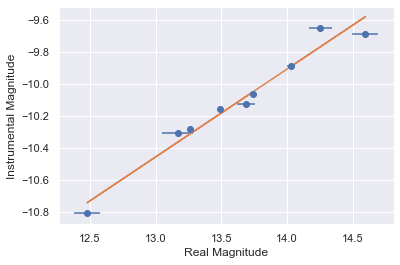

In [10]:
mags = np.array(mags)
Vmag = [15.219,14.947,13.739,13.407,13.321,14.724,15.319,14.591,15.406]
Vmag = np.array(Vmag)
Vmagerrors = [0.078,0.061,0.037,0.027,0.037,0.06,0.082,0.039,0.069]

rprime = [14.736,14.539,13.682,13.463,13.109,14.384,14.924,14.569,14.978]
rprimeerror = [0.081,0.064,0.049,0.074,0.042,0.042,0.05,0.053,0.085]

iprime = [14.19,14.201,13.66,13.542,12.909,13.969,14.978,14.633,14.516]
iprimeerror = [0.054,0.009,0.0102,0.099,0.083,0.0106,0.082,0.071,0.02]

Imag = []
Imagerror = []
for rp, ip, rperror, iperror in zip(rprime,iprime,rprimeerror,iprimeerror):
    r = rp +0.035*(rp-ip-0.21)
    rdrp = 1.035
    rdip = -0.035
    rerror = np.sqrt((rdrp**2)*rperror**2+(rdip**2)*iperror**2)
    
    i = ip + 0.041*(rp-ip-0.21)
    idrp = 0.041
    idip = 0.959
    ierror = np.sqrt((idrp**2)*rperror**2+(idip**2)*iperror**2)
    
   
    I = r-1.2444*(r-i)-0.382
    dr = -0.2444
    di = -1.2444
    Ierror = np.sqrt((dr**2)*(rerror**2)+(di**2)*(ierror**2))
    
    Imag.append(I)
    Imagerror.append(Ierror)
Imag = np.array(Imag)
Imagerror = np.array(Imagerror)



plt.errorbar(Imag,mags,xerr=Imagerror,yerr=magserrors,fmt='o')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(Imag, mags, sx = Imagerror, sy = None)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*Imag+myoutput.beta[1]
plt.plot(Imag,y)
myoutput.pprint()

In [11]:
xref = 641
yref = 345

mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
133 281.40071  155.1914 0.78694382 ...   0 32.978923 2.1950293 -0.85360081
289  640.7367 344.49264 0.82299144 ...   0 48868.391 2838.7035  -8.6328001


In [14]:
sourcemag = []
sourcemagerror = []
position = [(640.7367,344.49264)]
aperture = CircularAperture(position[0], r=3) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append(np.sqrt(((-1.08574/phot_table['aperture_sum_0'][0])**2)*(np.sqrt(phot_table['aperture_sum_0'][0])**2)))
print(sourcemag)

[-13.719824570776257]


In [15]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

7.04001419919539 +/- 1.1226386430991173
